In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split


In [4]:
use_builtins = True

# The data

## Download and prepare the dataset

In [5]:
# /content/drive/MyDrive/MasterThesis/paraphrasing/Parapgrasing-Masking.tsv

# Download the file
import pathlib

# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'
# path_to_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/Parapgrasing - Masking2.tsv')
# path_to_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/Parapgrasing-Masking-3.tsv')
# path_to_file = pathlib.Path('/content/drive/MyDrive/Master thesis/paraphrasing/ParapgrasingMask/Parapgrasing - Masking - maskWithWords.tsv')
path_to_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/ParapgrasingMask/ParaphrasingHSWithNotHS.tsv')


In [6]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  # inp = [inp for targ, inp in pairs]
  # targ = [targ for targ, inp in pairs]

  targ = [inp for targ, inp in pairs]
  inp = [targ for targ, inp in pairs]
  return targ, inp

In [7]:
targ, inp = load_data(path_to_file)
print(inp[3])

يا جابر يا بنجرجي يا مرتزق يا حثالة الحمدين يا خربوط يا ساذج يا مليق يا إمعه يا مسيلمة الكذاب يا هامشهري آغا ملالي إيراني يا زهرا مار يا يا يا يا تتشمت بمصر وأبناء مصر !! أتعلم بأنك لست برجل ولا يوصف بك كرجل ولا من اتباع الرجال انت أنت حثالة ومن أتباع الحثالة يا خسيس


In [8]:
print(targ[3])

يا جابر يا بنجرجي يا *****يا *****الحمدين يا *****يا ****يا ****يا ****يا ************ يا هامشهري آغا ملالي إيراني يا زهرا مار يا يا يا يا تتشمت بمصر وأبناء مصر !! أتعلم بأنك ******* ولا يوصف بك كرجل ولا من اتباع الرجال انت أنت *****ومن أتباع *******يا ****


## Create a tf.data dataset

In [9]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)

dataset = dataset.batch(BATCH_SIZE)
# dataset

In [ ]:
# train_size=1190
# val_size=400
# val_ds = dataset.take(val_size)    
# train_ds = dataset.skip(val_size).take(train_size)

In [10]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=1000):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds

In [11]:
get_dataset_partitions_tf(dataset,1592,0.8,0.2,True,1000)

(<TakeDataset shapes: ((None,), (None,)), types: (tf.string, tf.string)>,
 <TakeDataset shapes: ((None,), (None,)), types: (tf.string, tf.string)>)

In [ ]:
# val_dataset = dataset.enumerate() \
#                     .filter(lambda x,y: x % 5 == 0) \
#                     .map(lambda x,y: y)

# train_dataset = dataset.enumerate() \
#                     .filter(lambda x,y: x % 5 != 0) \
#                     .map(lambda x,y: y)
# tf.split(dataset, [train_dataset,val_dataset], axis=0, num=None, name="split")

# for i in val_dataset:
#     print(i)

# print()

# for i in train_dataset:
#     print(i)

In [12]:
for exam_input_batch, exam_target_batch in dataset.take(1):
  for i in range(5):
      print(exam_input_batch.numpy()[i].decode('utf-8'))
      # print()
      print(exam_target_batch.numpy()[i].decode('utf-8'))
      print()
  break

يا كتِفي و إِتكائي يا دِياري و العائلة يا ضوئِي و إنشراحي يا صديقِي يا حبيبي و السلام.. ❤️ -
يا كتِفي و إِتكائي يا دِياري و العائلة يا ضوئِي و إنشراحي يا صديقِي يا حبيبي و السلام.. ❤️ -

على اتحاد العار ان يستسمح الشوال ان يلعب المباراة بجمهور يا الف خساره يا بلد كل منقول خطوه للامام ييجى شوية عاهات يخدونا لوره
على اتحاد ال*** ان يستسمح الشوال ان يلعب المباراة بجمهور يا الف خساره يا بلد كل منقول خطوه للامام ييجى شوية ***** يخدونا لوره

كومنت حلو اننا ننهي بيه يا الكلام يا غزال ❤️تصبحو علي خير يا ولاد 😍
كومنت حلو اننا ننهي بيه يا الكلام يا غزال ❤️تصبحو علي خير يا ولاد 😍

آخ يا وجع قلبي يا معاذ :(
آخ يا وجع قلبي يا معاذ :(

وهو معكم أينمَا كُنتم يا طمأنينة القلب ، يا صدق اليقين .
وهو معكم أينمَا كُنتم يا طمأنينة القلب ، يا صدق اليقين .



In [ ]:
# for example_input_batch, example_target_batch in dataset.take(1):
#   for i in range(5):
#       print(example_input_batch.numpy()[i].decode('utf-8'))
#       # print()
#       print(example_target_batch.numpy()[i].decode('utf-8'))
#       print()
#   break

## Text preprocessing

In [22]:
example_text = tf.constant('#إغلاق_حسابات_البدون_في_البنوك الحل على إ رصاصة سلاإأم يا فيك يا فيه نقطه اخر السطر .')
print(example_text.numpy())
# print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'#\xd8\xa5\xd8\xba\xd9\x84\xd8\xa7\xd9\x82_\xd8\xad\xd8\xb3\xd8\xa7\xd8\xa8\xd8\xa7\xd8\xaa_\xd8\xa7\xd9\x84\xd8\xa8\xd8\xaf\xd9\x88\xd9\x86_\xd9\x81\xd9\x8a_\xd8\xa7\xd9\x84\xd8\xa8\xd9\x86\xd9\x88\xd9\x83 \xd8\xa7\xd9\x84\xd8\xad\xd9\x84 \xd8\xb9\xd9\x84\xd9\x89 \xd8\xa5 \xd8\xb1\xd8\xb5\xd8\xa7\xd8\xb5\xd8\xa9 \xd8\xb3\xd9\x84\xd8\xa7\xd8\xa5\xd8\xa3\xd9\x85 \xd9\x8a\xd8\xa7 \xd9\x81\xd9\x8a\xd9\x83 \xd9\x8a\xd8\xa7 \xd9\x81\xd9\x8a\xd9\x87 \xd9\x86\xd9\x82\xd8\xb7\xd9\x87 \xd8\xa7\xd8\xae\xd8\xb1 \xd8\xa7\xd9\x84\xd8\xb3\xd8\xb7\xd8\xb1 .'


In [ ]:
# example_text = tf.constant('يا حيوان يا متخلف هو قال لو للزمالك هقول جول بس طالما ل حسنيه اغادير هقول فيها شك و التصوير مش واضح دي تسميه ايه يا قذر يا حثاله')
# print(example_text.numpy().decode('utf-8'))
# print(tf_text.normalize_utf8(example_text, 'NFKD').numpy().decode('utf-8'))

In [ ]:
# example_text = tf.constant('علي شحم يا طاقية يا عنصري القم بس')
# print(example_text.numpy().decode('utf-8'))
# print(tf_text.normalize_utf8(example_text, 'NFKD').numpy().decode('utf-8'))

In [15]:
import re
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>@,\\-_”“٪ًَ]"

def tf_lower_and_split_punct(text):
  text = tf.strings.regex_replace(text, '[إأآا]', 'ا')
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  # text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.

  text = tf.strings.regex_replace(text, '[.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿_#]', r' \0 ')
  # Strip whitespace.


  # text = tf.strings.strip(text)
  # text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  # text = tf.strings.regex_replace(text, r'(.)\1+', r'\1\1')
  text = tf.strings.regex_replace(text,text_cleaning_re, '')
  text = tf.strings.regex_replace(text, 'ى', 'ي')
  text = tf.strings.regex_replace(text, "ة", "ه")

  text = tf.strings.regex_replace(text, '[إأآا]', 'ا')


  # text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  # text = re.sub("[إأآا]", "ا", str(text))
  # text = re.sub("ى", "ي", str(text))
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [16]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

#إغلاق_حسابات_البدون_في_البنوك الحل على إ رصاصة سلاإأم يا فيك يا فيه نقطه اخر السطر .
[START]   اغلاق  حسابات  البدون  في  البنوك الحل علي ا رصاصه سلااام يا فيك يا فيه نقطه اخر السطر  [END]


## Text Vectorization

In [17]:
max_vocab_size = 5000
####TextVectorization Before paraphrasing

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    # output_mode="int",

    max_tokens=max_vocab_size
    
    )
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 'يا',
 '[START]',
 '[END]',
 'و',
 'من',
 'الله',
 'في',
 'ما',
 'علي',
 'انت',
 'لا',
 'كل',
 'رب',
 'اللي',
 'ولا',
 'انا',
 'ان',
 'ابن']

In [18]:
#TextVectorization after paraphrasing(masking)

output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 'يا',
 '[START]',
 '[END]',
 'و',
 'من',
 'الله',
 'في',
 'ما',
 'علي',
 '****',
 '****يا',
 'لا',
 'انت',
 'كل',
 '*****يا',
 'رب',
 '*****',
 'اللي']

In [25]:
#Now these layers can convert a batch of strings into a batch of token IDs:

# example_tokens = input_text_processor(example_input_batch)
# example_tokens[:3, :10]

In [26]:
#The get_vocabulary method can be used to convert token IDs back to text:

input_vocab = np.array(input_text_processor.get_vocabulary())
# tokens = input_vocab[example_tokens[0].numpy()]
# ' '.join(tokens)

Text(0.5, 1.0, 'Mask')

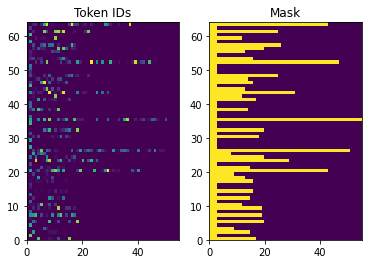

In [ ]:
#The returned token IDs are zero-padded. This can easily be turned into a mask:

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

#The encoder/decoder model

In [27]:
embedding_dim = 256
units = 1024

##The encoder

In [28]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [29]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [33]:
# Convert the input text to tokens.
# example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
# example_enc_output, example_enc_state = encoder(example_tokens)

# print(f'Input batch, shape (batch): {example_input_batch.shape}')
# print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
# print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
# print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

##The attention head

In [34]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

##Test the Attention layer

In [35]:
attention_layer = BahdanauAttention(units)

In [37]:
# (example_tokens != 0).shape

In [39]:
# Later, the decoder will generate this attention query
# example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

NameError: ignored

Text(0.5, 1.0, 'Mask')

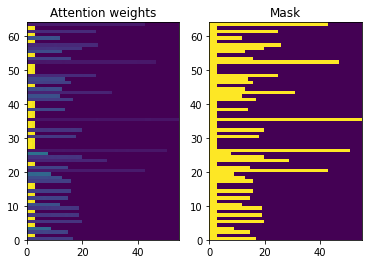

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
attention_weights.shape

TensorShape([64, 2, 55])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

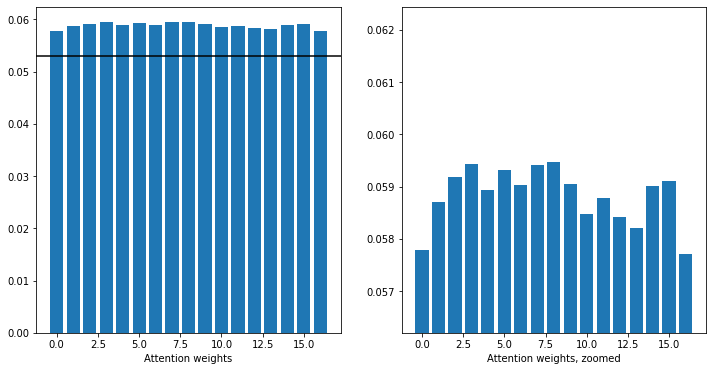

In [ ]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

##The decoder

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [43]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [44]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state
  

In [45]:
Decoder.call = call

In [46]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [48]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

AttributeError: ignored

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['ههههه'],
       ['النظر'],
       ['يدخلها'],
       ['والاخره'],
       ['حاجات']], dtype='<U130')

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['عملت'],
       ['حميدتي'],
       ['ورور'],
       ['وبعد'],
       ['هازارد']], dtype='<U130')

#Training

## Define the loss function

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

## Implement the training step

In [ ]:
#Implement the training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

## Test the training step

In [ ]:
#Test the training step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    metrics=["accuracy"]
)

In [ ]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.853183>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8123755>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.7104645>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.324674>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.219875>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9993935>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.000094>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8806725>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5327506>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.273918>}

CPU times: user 18.3 s, sys: 510 ms, total: 18.8 s
Wall time: 18.9 s


In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.171023>}

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.244338>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.34812>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3949575>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3496194>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2320247>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1143475>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0494304>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0302052>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0511603>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0874496>}

CPU times: user 12.7 s, sys: 1.28 s, total: 13.9 s
Wall time: 9.04 s


....................................................................................................


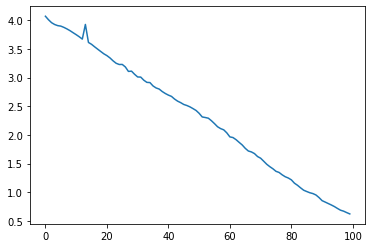

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    metrics=["accuracy"]
)

## Train the model

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
from keras.callbacks import EarlyStopping


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='batch_loss',patience=5),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
    #                                  min_lr = 0.01,
    #                                  monitor = 'val_loss',
    #                                  verbose = 1)
    # batch_loss = BatchLogs('batch_loss')
]

In [ ]:
train_translator.fit(dataset, epochs=50,callbacks=my_callbacks)

Epoch 1/50
48/48 [==============================] - 46s 867ms/step - batch_loss: 5.7045
Epoch 2/50
48/48 [==============================] - 41s 861ms/step - batch_loss: 4.8195
Epoch 3/50
48/48 [==============================] - 41s 851ms/step - batch_loss: 4.5537
Epoch 4/50
48/48 [==============================] - 42s 869ms/step - batch_loss: 4.3140
Epoch 5/50
48/48 [==============================] - 42s 878ms/step - batch_loss: 4.0894
Epoch 6/50
48/48 [==============================] - 41s 864ms/step - batch_loss: 3.8205
Epoch 7/50
48/48 [==============================] - 42s 859ms/step - batch_loss: 3.5343
Epoch 8/50
48/48 [==============================] - 41s 850ms/step - batch_loss: 3.1389
Epoch 9/50
48/48 [==============================] - 41s 858ms/step - batch_loss: 2.6991
Epoch 10/50
48/48 [==============================] - 42s 873ms/step - batch_loss: 2.2225
Epoch 11/50
48/48 [==============================] - 41s 856ms/step - batch_loss: 1.7039
Epoch 12/50
48/48 [===========

Text(0, 0.5, 'CE/token')

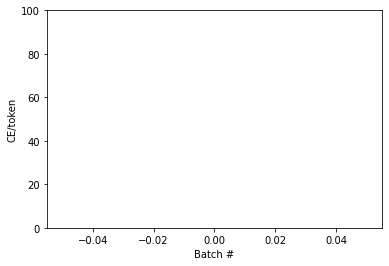

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 100])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

#Translate

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder  
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

##Convert token IDs to text

In [ ]:
#Convert token IDs to text
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'\xd8\xa7\xd8\xaf\xd8\xa8 \xd9\x88\xd8\xa7\xd8\xad\xd9\x81\xd8\xa7\xd8\xaf',
       b'********* \xd8\xb5\xd8\xba\xd8\xa7\xd8\xb1',
       b'\xd9\x81\xd9\x8a\xd9\x84\xd8\xb3\xd9\x88\xd9\x81 \xd9\x8a\xd8\xa7\xd8\xb1\xd8\xa8',
       b'\xd9\x84\xd8\xb3\xd8\xaa\xd9\x85 \xd9\x88\xd9\x85\xd9\x8a\xd8\xaa',
       b'\xd8\xa7\xd9\x84\xd9\x85\xd8\xb3\xd9\x88\xd9\x94\xd9\x88\xd9\x84\xd9\x8a\xd9\x87 \xd9\x88\xd8\xac\xd9\x87\xd9\x87'],
      dtype=object)

## Sample from the decoder's predictions

In [ ]:
#Sample from the decoder's predictions

def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2505],
       [1224],
       [1020],
       [3568],
       [4966]])>

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1329],
       [4445],
       [4636],
       [1013],
       [3139]])>

## Implement the translation loop

In [ ]:
#Implement the translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
%%time
input_text = tf.constant([
    'بكري يا معرص يا عار الصعيد ملعون ضهر ابوك يا عرص', # "It's really cold here."
    'تبا لكم ولأشكالكم', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

يوفنتوس يا ****يا *** ال**** ***** وال****** **** يا ***
تبا لكم ممالك

CPU times: user 233 ms, sys: 6.29 ms, total: 240 ms
Wall time: 249 ms


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 16.5 s, sys: 421 ms, total: 16.9 s
Wall time: 16.8 s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

يوفنتوس يا يا ***ال***** ال**** ال*** يا ***
تبا لكم نزلتي الاول

CPU times: user 147 ms, sys: 16.1 ms, total: 163 ms
Wall time: 129 ms


## Visualize the process

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.0000001  1.0000001  1.         1.0000001  0.99999994 1.
 1.         1.         1.0000001  1.0000001  0.99999994 1.
 0.99999994 1.         1.         1.         1.         1.
 0.99999994 1.         1.         1.         1.         0.99999994
 1.0000001  1.         1.         1.         0.9999999  1.
 1.         0.99999994 1.         0.9999999  1.0000001  0.99999994
 1.         1.0000001  0.99999994 1.0000001  1.0000001  0.99999994
 1.         1.         0.9999999  1.         1.         1.
 1.0000001  1.        ]


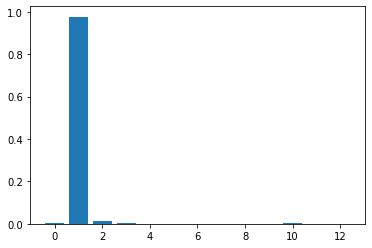

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

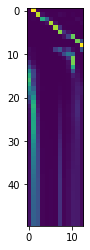

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

## Labeled attention plots

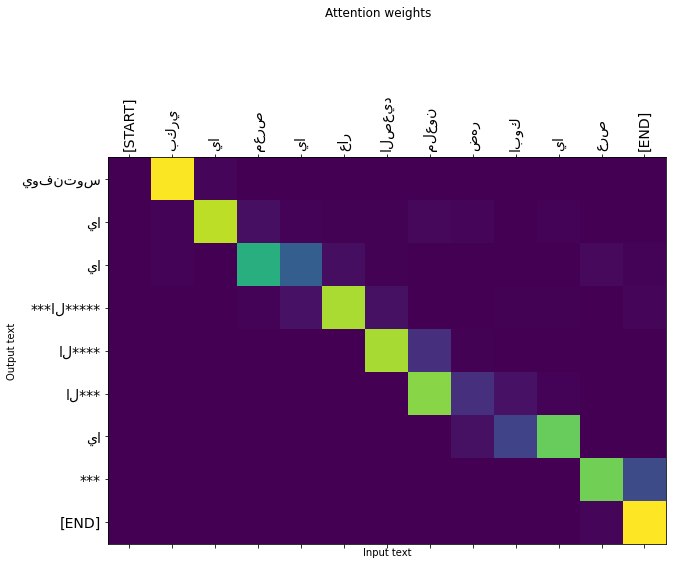

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [ ]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'يا راس هرم الفساد ف مصر معلش انت مش عارف تشغلهم',
    # Are they still home?
    'برجل ولا يوصف بك كرجل ولا من اتباع الرجال انت أنت حثالة ومن أتباع الحثالة يا خسيس',
    # Try to find out.'
    'كسمك يا بكاري يا جساما يا ابن المنايك',
    'فين يا ابن القحبه يا معرص السودان مش هيعملوا اَي شي من مخططكم هاهاهاهاها و لسه يا خونه',
    'يا حقير يا واطي يا داعر يا روكي لوليتش قاعد يلعب مصارعة 5 كورة يضرب فيها وما ياخذ عليها كرت ولا حتى فاول !!!!!!!!!!!!!!!!!!!!!'
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

يا جعفر ال***** ف مصر معلش انت مش عارف ملتك منك مش ايش ملتك عمك انت مش اشكالك ويوم ال***
ههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههه باي شغلك سخيف و من السودان ولك انت انت ***** ومن الاهلي التعديلات خلو احد بردو يا ****
****يا فتحي يا جساما يا جساما يا ابن ********
فين يا ابن ال**** يا **** السودان مش هيعملوا اي شي من ل**** يا ****
يا ****يا ****يا ****يا *****يا ***** ***** هذا تعرف فيها وما يسقط عليها كرت ولا حتي فاول

CPU times: user 158 ms, sys: 19.9 ms, total: 178 ms
Wall time: 143 ms


In [ ]:
result['text'][1].numpy().decode()

'ههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههه باي شغلك سخيف و من السودان ولك انت انت ***** ومن الاهلي التعديلات خلو احد بردو يا ****'

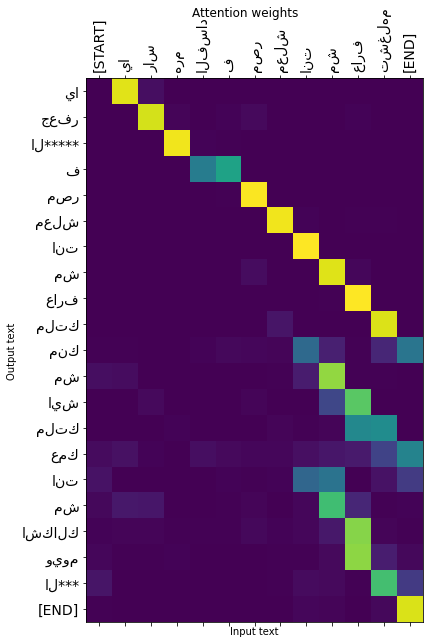

In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

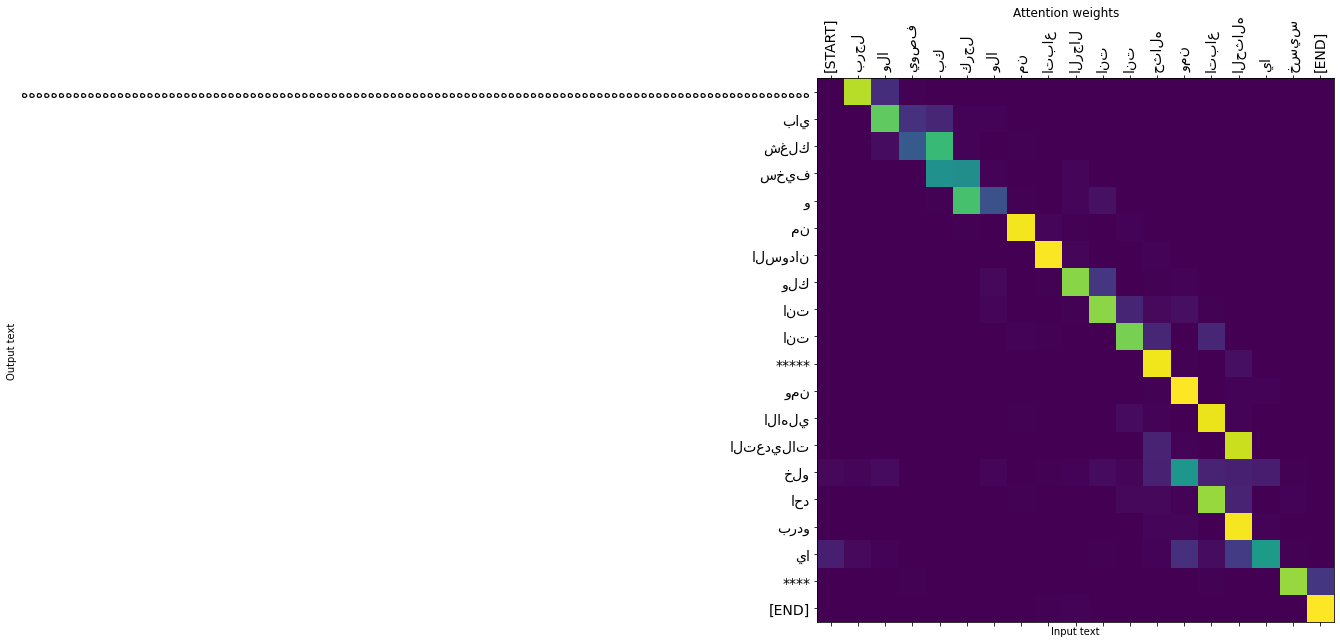

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

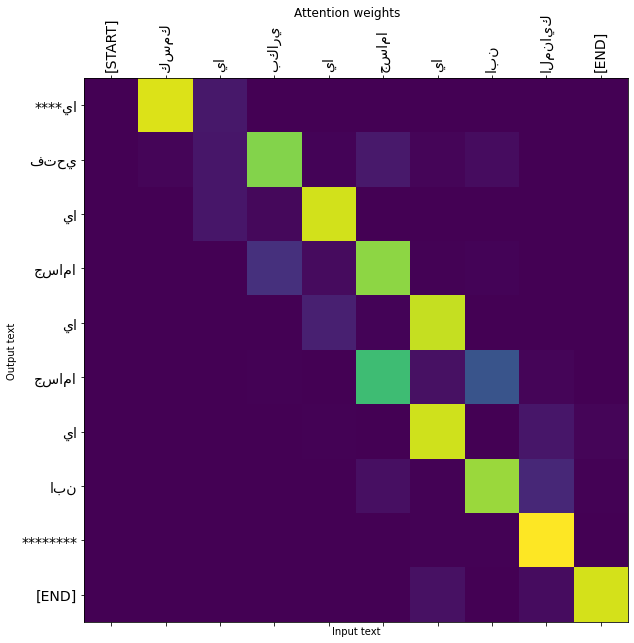

In [ ]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 *****


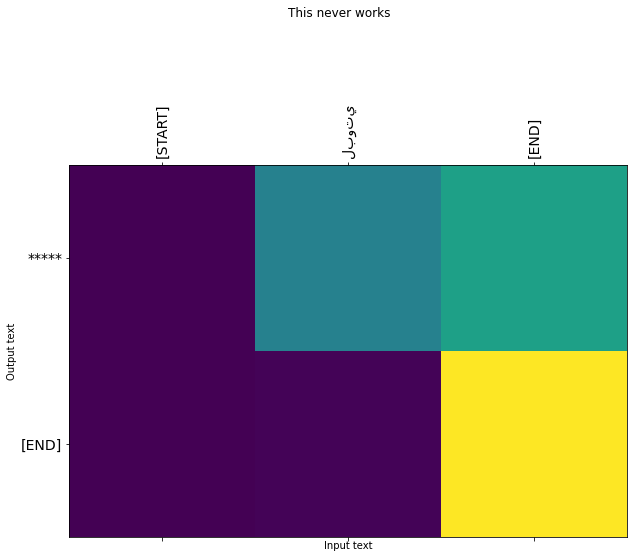

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

#Blue score

In [ ]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
# reference = [['@USER @USER كسمك يا ابن العرص يا اللي امك زانيه اهلي ميين اللي مستواه كده واهلي ميين اللي الخكام بتسانده يا ابن المره الفاجره']]
reference = str('@USER @USER كسمك يا ابن العرص يا اللي امك زانيه اهلي ميين اللي مستواه كده واهلي ميين اللي الخكام بتسانده يا ابن المره الفاجره').split()
candidate = str('@USER @USER **** يا ابن ***** يا اللي امك ***** اهلي ميين اللي مستواه كده واهلي ميين اللي الخكام بتسانده يا ابن المره *******').split()
print('Individual 1-gram: %f' % sentence_bleu([reference], candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu([reference], candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu([reference], candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu([reference], candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.833333
Individual 2-gram: 0.695652
Individual 3-gram: 0.545455
Individual 4-gram: 0.476190


In [ ]:
test_file = pathlib.Path('/content/drive/MyDrive/Master thesis/paraphrasing/paraphrasingTest.tsv')

targ_test, inp_test = load_data(test_file)

test_dataset = tf.data.Dataset.from_tensor_slices((inp_test, targ_test)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in test_dataset.take(1):
  for i in range(5):
      print(example_input_batch.numpy()[i].decode('utf-8'))
      # print()
      print(example_target_batch.numpy()[i].decode('utf-8'))
      print()
  break

حمودي عاوز اعمل حفله عليك بس خالي بالك انا بوسع خرم الطيز يعني هخاليك خراره يا حمودي يا شقي خالص
حمودي عاوز اعمل حفله عليك بس خالي بالك انا بوسع خرم ***** يعني هخاليك ***** يا حمودي يا شقي خالص

قبل كم يا غشيم يا صغير يا متذيل خلك تحت صوتك ما نسمعه
قبل كم يا **** يا **** يا ***** خلك تحت صوتك ما نسمعه

حقيقي بستحقر الناس عديمه الرأي (يمين يمين شمال شمال )، مسالمه وخلاص ،والاشخاص السلبيه والضعفاء حقيقي اربع شخصيات عايزين الحرق انتم ملمكش لزمه كبني آدمين ملكمش لزمه يا مهزأين يا مهززززأين انتم عبء علي البشر يا مهزأين
حقيقي ****** الناس ***** الرأي (يمين يمين شمال شمال )، مسالمه وخلاص ،والاشخاص السلبيه والضعفاء حقيقي اربع شخصيات عايزين ***** انتم ملمكش لزمه كبني آدمين ملكمش لزمه يا ****** يا ********* انتم ** علي البشر يا ******

انتوا بتعرفوا منين اننا مبنتكلمش يا بنات يا قمرات يا خنازير
انتوا بتعرفوا منين اننا مبنتكلمش يا بنات يا قمرات يا ******

كنت داخل أديلك شويه في جنابك لاقيت المصريين الشرفاء أعطوك حقك في الرد لتعرف قيمتك ياقطري يا خسيس يا شويه خونه زي تميمكم هكذا أنتم يا شويه خونه.

In [ ]:
print(inp_test[2:3])

['باقي البيان وينو ما شفنه يا برهان ورينا يا برهان ورينا شو بيحصل في شلة الكيزان سلم بشير العار للحاكم السجان وباقي الكل…']


In [ ]:
test_input_text = tf.constant(inp_test[:402])

test_result = translator.tf_translate(test_input_text)

for tr in test_result['text']:
  print(tr.numpy().decode())
  # list(tr.split("\n"))

print()

اما انت *****يا قمر لا يجي وحيد الاقيك تقبل ال***** يا *****يا **** ال****** من ****ايران نصيب يا *****يا **** ال**** بتاع كفايه منو منو بس هبوط شرف *** ال**** عليك
هيثم هيثم ان ايه 😂 يا**** يا ******يا تركي نواعم 😂
هههههههههههههههههههههه علي ما *****اولا يا رجال ******في جبار ال***** للعراق في المستقبل الكيزان العربي تعلمين
هنزفك يا الحق يا ****يا *****من سفك يا ***** ال*** ****يا نشوتك *****
وكما دعوه هذا يا ****يا منتفع ال****** ع وجهك ال***** ال***** عليك يا ******
هم ال**** لغايه يا ****يا ***يا ***يا ****** ****** ****** هز هذا والا هي يكونو منعش للاعب والقتل ليبيا و****
****يا ابن ابن *****يا اللي امك وحكومتك واخواتك اللي ال*** عن هلكيك ******** اللي ****
يا ****يا *****يا انت *****لا **** مك يا**** ****في ***يا **** ال**** وتندحروا ال**** ال****** في ممالك مواجه تقول في ميكرفون الاهلي انتم ال**** ال***** في ربع
منتا في ذا مفيهاش و*** فكحتها ما ****الناس وايده ثانيا اكيد انت ال**** هيمني ****في *****يا مكان يا ****يا مزه و***** ل***** يا *****يا ***انت ******
والكلام الاهلي لن ه

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def bleu_score():

  predicted = []
  for tr in range(len(inp_test)):
  # for tr in range(5):
    test_input_text = tf.constant(inp_test)
    # print('salam1',test_input_text)
    # test_input_text = tf.constant(inp_test[:5])
    test_result = translator.tf_translate(test_input_text)
    # print('salam 2',test_result)
    # test_result = translator.tf_translate(test_input_text[:5])
    test_result= test_result['text'][tr].numpy().decode()
    # print('salam3',test_result)
    predicted_list = list(test_result.split("\n"))
    # print('salam4',predicted_list)
    predicted.append(predicted_list)
  # print('Predicted List',predicted)

  bleu_dic = {}
  # bleu_dic['1-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(1.0, 0, 0, 0))
  # bleu_dic['1-2-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(0.5, 0.5, 0, 0))
  # bleu_dic['1-3-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(0.3, 0.3, 0.3, 0))
  # bleu_dic['1-4-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(0.25, 0.25, 0.25, 0.25))
  # predicted = str('اما انت تقعد طول عمرك لا مبدا ولا راي ثابت يا ***** . اقسم بربي ماتجي حاجة يا ***** يا **** الانكليز . راس مالك كلام بس . عقاب **** . معمر سيد وحفتر راح يركب عليك . ')
  # targ_test = str('اما انت تقعد طول عمرك لا مبدا ولا راي ثابت يا ***** . اقسم بربي ماتجي حاجة يا ***** يا **** الانكليز . راس مالك كلام بس . عقاب **** . معمر سيد وحفتر راح يركب عليك . ')

  # predicted = ['']
  bleu_dic['1-grams'] = corpus_bleu([targ_test], predicted, weights=(1.0, 0, 0, 0))
  bleu_dic['1-2-grams'] = corpus_bleu([targ_test], predicted, weights=(0.5, 0.5, 0, 0))
  bleu_dic['1-3-grams'] = corpus_bleu([targ_test], predicted, weights=(0.3, 0.3, 0.3, 0))
  bleu_dic['1-4-grams'] = corpus_bleu([targ_test], predicted, weights=(0.25, 0.25, 0.25, 0.25))
  res = "\n\n\n".join("Input: {} \nActual: {} \nPredicted: {}".format(x, y,z) for x, y, z in zip(inp_test, targ_test, predicted))
  # print(" \n-------------\n BLUE SCORE : \n-------------\n ",bleu_dic, "\n\n\n-------------\n")

  print(res , "\n\n\n-------------\n")

  return bleu_dic


bleu_test = bleu_score()
bleu_test

AssertionError: ignored

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()